LOADING AND DISPLAYINNG COVER IMAGE

In [1]:
import builtins
len = builtins.len

In [2]:
from PIL import Image
import numpy as np

def load_color_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_rgb = np.array(img, dtype=np.uint8)
    return img_rgb

def int_to_8bit_binary(value):
    return format(int(value), '08b')


def rgb_pixel_to_8bit(rgb_pixel):
    r, g, b = rgb_pixel
    return (
        int_to_8bit_binary(r),
        int_to_8bit_binary(g),
        int_to_8bit_binary(b)
    )


def image_rgb_to_8bit(img_rgb):
    H, W, _ = img_rgb.shape
    img_bin = [[[None, None, None] for _ in range(W)] for _ in range(H)]

    for i in range(H):
        for j in range(W):
            r, g, b = img_rgb[i, j]
            img_bin[i][j][0] = int_to_8bit_binary(r)
            img_bin[i][j][1] = int_to_8bit_binary(g)
            img_bin[i][j][2] = int_to_8bit_binary(b)

    return img_bin


In [3]:
def preprocess_cover_to_8bit(image_path):
    img_rgb= load_color_image(image_path)
    img_bin= image_rgb_to_8bit(img_rgb)
    return img_bin

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def display_cover_image_binary(cover_img_bin, title="Cover Image", save_path=None):
    # cover_img_bin : (H,W,3) where each entry is an 8-bit string
    H = len(cover_img_bin)
    W = len(cover_img_bin[0])

    img = np.zeros((H, W, 3), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            img[i, j, 0] = int(cover_img_bin[i][j][0], 2)  # R
            img[i, j, 1] = int(cover_img_bin[i][j][1], 2)  # G
            img[i, j, 2] = int(cover_img_bin[i][j][2], 2)  # B

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


LOADING SECRET IMAGE AND CONVERSION TO 6BIT FORMAT

In [5]:
from PIL import Image
import numpy as np
import math

def load_gray_image(image_path):
    img = Image.open(image_path).convert("L")
    img_gray = np.array(img, dtype=np.uint8)
    return img_gray


def grayscale_to_8bit_binary(img_gray):
    H, W = img_gray.shape
    bin_img = [[None for _ in range(W)] for _ in range(H)]

    for i in range(H):
        for j in range(W):
            bin_img[i][j] = format(int(img_gray[i, j]), '08b')
    return bin_img


def flatten_binary_image(bin_img):
    bitstream = []

    for row in bin_img:
        for pixel_bin in row:
            bitstream.extend([int(b) for b in pixel_bin])
    return bitstream



def split_to_6bit_blocks(bitstream):
    padding = (6 - (__builtins__.len(bitstream) % 6)) % 6
    bitstream = bitstream + [0] * padding

    blocks_6bit = []
    for i in range(0, __builtins__.len(bitstream), 6):
        blocks_6bit.append(bitstream[i:i+6])
    return blocks_6bit



def reshape_blocks_to_2d(blocks_6bit, W_cover):
    M = len(blocks_6bit)
    H_needed = math.ceil(M / W_cover)

    padded_blocks = blocks_6bit + [[0]*6] * (H_needed * W_cover - M)

    blocks_2d = []
    for y in range(H_needed):
        row = padded_blocks[y*W_cover : (y+1)*W_cover]
        blocks_2d.append(row)

    return blocks_2d


def pad_2d_to_power_of_two(blocks_2d):
    H = len(blocks_2d)
    W = len(blocks_2d[0])

    H2 = 1 << math.ceil(math.log2(H))
    W2 = 1 << math.ceil(math.log2(W))

    zero_block = [0]*6
    # Pad rows
    for row in blocks_2d:
        row.extend([zero_block] * (W2 - W))
    # Pad columns
    for _ in range(H2 - H):
        blocks_2d.append([zero_block] * W2)
    return blocks_2d


In [6]:
def preprocess_grayscale_to_6bit_2d(image_path,l):
    img_gray = load_gray_image(image_path)
    bin_img = grayscale_to_8bit_binary(img_gray)
    bitstream = flatten_binary_image(bin_img)
    blocks_6bit = split_to_6bit_blocks(bitstream)
    blocks_2d=reshape_blocks_to_2d(blocks_6bit,l)
    img_gray_6= pad_2d_to_power_of_two(blocks_2d)
    return img_gray_6


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def display_secret_before_decomposition(secret_path, title="Secret Image (Original)", save_path=None):
    
    img_gray = load_gray_image(secret_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img_gray, cmap="gray", vmin=0, vmax=255)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()



def display_secret_after_decomposition(img_gray_6, title="Secret Image After Decomposition", save_path=None):
    # img_gray_6 : (H,W,6)
    # Each 6-bit block is in (0–63).

    H = len(img_gray_6)
    W = len(img_gray_6[0])

    img = np.zeros((H, W), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            bits = img_gray_6[i][j]    
            value = int("".join(map(str, bits)), 2)
            img[i, j] = value               

    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap="gray", vmin=0, vmax=63)
    plt.axis("off")
    plt.title(title)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)

    plt.show()


LOADING BOTH IMAGES TO QC

In [8]:
def build_base_ci_si(img_bin,img_gray_6):
    # Dimension verification
    H = len(img_bin)
    assert all(len(row) == H for row in img_bin)
    ky = kx = int(np.log2(H))
    assert 2**kx == H, "H must be power of 2"

    # Register creation
    y = QuantumRegister(ky, "y")
    x = QuantumRegister(kx, "x")
    cover_q = QuantumRegister(24, "CI")
    secret_q = QuantumRegister(6,"SI")
    anc    = QuantumRegister(ky+kx-2, "anc")

    qc = QuantumCircuit(
        y, x, cover_q,secret_q, anc
    )

    # Load |CI⟩ into qc from given format cover image
    qc.h(y)
    qc.h(x)

    for y_val in range(H):
        y_bits = format(y_val, f"0{ky}b")
        for x_val in range(H):
            x_bits = format(x_val, f"0{kx}b")

            for i, b in enumerate(y_bits):
                if b == "0":
                    qc.x(y[i])
            for i, b in enumerate(x_bits):
                if b == "0":
                    qc.x(x[i])

            controls = list(y) + list(x)
            # Loading color image
            for c in range(3):
                bits = img_bin[y_val][x_val][c]
                for b, bit in enumerate(bits):
                    if bit == "1":
                        qc.mcx(controls, cover_q[c*8 + b],anc)
                        
            for i, bit in enumerate(img_gray_6[y_val][x_val]):
                if bit == 1:
                    qc.mcx(controls, secret_q[i],anc)
                      
            for i, b in enumerate(x_bits):
                if b == "0":
                    qc.x(x[i])
            for i, b in enumerate(y_bits):
                if b == "0":
                    qc.x(y[i])

    return qc, {
        "y": y, "x": x, "cover_q": cover_q,
        'secret_q':secret_q,anc : "anc"
    }


COMPARATOR CIRCUIT MAKING

1. equality_comparator -> for comparing any registers value
2. comparator_2d -> checking position equality

In [9]:
def equality_comparator(qc, reg_a, reg_b, flag, anc):
    # flag = 1 iff reg_a == reg_b
    # anc have same length as reg_a
    # All ancilla are returned to |0>

    k = len(reg_a)

    # anc[i] = a[i]^b[i]
    for i in range(k):
        qc.cx(reg_a[i], anc[i])
        qc.cx(reg_b[i], anc[i])

    # flag = XNOR(anc)
    qc.x(anc)
    qc.mcx(list(anc), flag)
    qc.x(anc)

    # uncompute anc
    for i in reversed(range(k)):
        qc.cx(reg_b[i], anc[i])
        qc.cx(reg_a[i], anc[i])


In [10]:
def comparator_2d(
    qc,
    x_c, y_c,
    x_s, y_s,
    flag,
    anc_x, anc_y,
    flag_x, flag_y
):
    # flag = 1 iff (x_c == x_s) AND (y_c == y_s)
    # All ancilla and intermediate flags are uncomputed afterwards

    # x comparison
    equality_comparator(qc, x_c, x_s, flag_x[0], anc_x)

    # y comparison
    equality_comparator(qc, y_c, y_s, flag_y[0], anc_y)

    # AND the results
    qc.ccx(flag_x[0], flag_y[0], flag)

    # uncompute y comparison
    equality_comparator(qc, y_c, y_s, flag_y[0], anc_y)

    # uncompute x comparison
    equality_comparator(qc, x_c, x_s, flag_x[0], anc_x)


EMBEDDING CIRCUIT

In [11]:
def controlled_embed_gray_lsb(
    qc, controls,
    b_hi, b_lo,
    secret, target,
    anc
):

    qc.mcx(controls + [b_hi],   anc)
    qc.mcx(controls + [b_lo],   anc)
    qc.mcx(controls + [secret], anc)

    qc.mcx(controls + [anc], target)

    qc.mcx(controls + [secret], anc)
    qc.mcx(controls + [b_lo],   anc)
    qc.mcx(controls + [b_hi],   anc)


In [12]:
def controlled_full_pixel_gray_embedding(
    qc, controls,
    cover_q, secret_q,
    anc
):
    # s5,s4,s3 → r1,b1,g1
    controlled_embed_gray_lsb(qc, controls, cover_q[5],  cover_q[6],  secret_q[0], cover_q[6],  anc[0])
    controlled_embed_gray_lsb(qc, controls, cover_q[13], cover_q[14], secret_q[1], cover_q[14], anc[1])
    controlled_embed_gray_lsb(qc, controls, cover_q[21], cover_q[22], secret_q[2], cover_q[22], anc[2])
    # s2,s1,s0 → r
    controlled_embed_gray_lsb(qc, controls, cover_q[6],  cover_q[7],  secret_q[3], cover_q[7],  anc[3])
    controlled_embed_gray_lsb(qc, controls, cover_q[14], cover_q[15], secret_q[4], cover_q[15], anc[4])
    controlled_embed_gray_lsb(qc, controls, cover_q[22], cover_q[23], secret_q[5], cover_q[23], anc[5])

EXTRACTION CIRCUIT 

In [13]:
def controlled_extract_gray_lsb(
    qc, controls,
    b_hi, b_lo,
    si_rec
):
    """
    si_rec ^= (b_hi ⊕ b_lo)
    anc restored to |0>
    """

    qc.mcx(controls + [b_hi],   si_rec)
    qc.mcx(controls + [b_lo],   si_rec)

In [14]:
def controlled_full_pixel_gray_extraction(
    qc, controls,
    cover_q, si_rec
):
    # s5,s4,s3 ← r1,b1,g1
    controlled_extract_gray_lsb(qc, controls, cover_q[5],  cover_q[6],   si_rec[0])
    controlled_extract_gray_lsb(qc, controls, cover_q[13], cover_q[14],  si_rec[1])
    controlled_extract_gray_lsb(qc, controls, cover_q[21], cover_q[22],  si_rec[2])
    # s2, s1, s0 <- r0,g0,b0
    controlled_extract_gray_lsb(qc, controls, cover_q[6],  cover_q[7],   si_rec[3])
    controlled_extract_gray_lsb(qc, controls, cover_q[14], cover_q[15],  si_rec[4])
    controlled_extract_gray_lsb(qc, controls, cover_q[22], cover_q[23],  si_rec[5])


#### PIXEL WISE QC

In [15]:
from qiskit import QuantumCircuit, QuantumRegister
import numpy as np

def build_qc_full(img_bin, img_gray_6):

    H = len(img_bin)
    ky = kx = int(np.log2(H))
    assert 2**kx == H

    # Registers
    y = QuantumRegister(ky, "y")
    x = QuantumRegister(kx, "x")
    cover_q  = QuantumRegister(24, "CI")
    secret_q = QuantumRegister(6,  "SI")
    si_rec   = QuantumRegister(6,  "si_rec")

    # single clean ancilla for parity
    # anc = QuantumRegister(ky+kx -2, "anc")
    flag= QuantumRegister(6,"flag")
    qc = QuantumCircuit(y, x, cover_q, secret_q, si_rec,flag)

    # address superposition
    qc.h(y)
    qc.h(x)

    for y_val in range(H):
        y_bits = format(y_val, f"0{ky}b")
        for x_val in range(H):
            x_bits = format(x_val, f"0{kx}b")

            # activate |y_val, x_val>
            for i, b in enumerate(y_bits):
                if b == "0":
                    qc.x(y[i])
            for i, b in enumerate(x_bits):
                if b == "0":
                    qc.x(x[i])

            controls = list(y) + list(x)

            # ---- Load CI ----
            for c in range(3):
                for b, bit in enumerate(img_bin[y_val][x_val][c]):
                    if bit == "1":
                        qc.mcx(controls, cover_q[c*8 + b])

            # ---- Load SI ----
            for i, bit in enumerate(img_gray_6[y_val][x_val]):
                if bit == 1:
                    qc.mcx(controls, secret_q[i])

            # ---- Embed ----
            controlled_full_pixel_gray_embedding(
                qc, controls, cover_q, secret_q, flag
            )
            #  # ---- UNLoad SI ----
            # for i, bit in enumerate(img_gray_6[y_val][x_val]):
            #     if bit == 1:
            #         qc.mcx(controls, secret_q[i])

            # ---- Extract ----
            controlled_full_pixel_gray_extraction(
                qc, controls, cover_q, si_rec
            )

            # uncompute address
            for i, b in enumerate(x_bits):
                if b == "0":
                    qc.x(x[i])
            for i, b in enumerate(y_bits):
                if b == "0":
                    qc.x(y[i])

    return qc, {
        "y": y,
        "x": x,
        "cover_q": cover_q,
        "secret_q": secret_q,
        "si_rec": si_rec,
        "flag": flag
    }


MEASURING THE QC

In [16]:
from qiskit import ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile

def measure_secret_neqr_after(qc, regs, shots=1024, method="matrix_product_state"):
    """
    Output format :
    | y_n...y_0| x_n....x_0| c_23 c_22 ..... c_0| s5 s4 s3 s2 s1 s0 | si_rec_5 ......si_rec_0| flags|
    """

    y = regs["y"]
    x = regs["x"]
    cover_q = regs['cover_q']
    secret_q = regs['secret_q']
    si_rec = regs['si_rec']
    flag= regs['flag']
    ky = len(y)
    kx = len(x)
    cl = ClassicalRegister(ky + kx +2*len(secret_q)+len(cover_q)+len(flag), "cl_neqr")
    qc.add_register(cl)

    idx = 0
    for q in reversed(flag):
        qc.measure(q, cl[idx])
        idx += 1
        
    for q in reversed(si_rec):
        qc.measure(q, cl[idx])
        idx += 1
        
    for q in reversed(secret_q):
        qc.measure(q, cl[idx])
        idx += 1
        
    for q in reversed(cover_q):
        qc.measure(q, cl[idx])
        idx += 1
        
    # ---- x register (MSB → LSB) ----
    for q in reversed(x):
        qc.measure(q, cl[idx])
        idx += 1

    # ---- y register (MSB → LSB) ----
    for q in reversed(y):
        qc.measure(q, cl[idx])
        idx += 1



    backend = AerSimulator(method=method)
    tqc = transpile(qc, backend, optimization_level=3)
    result = backend.run(tqc, shots=shots).result()

    return result.get_counts()




In [17]:
def display_the_hist(counts):
 if counts:
    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}

    # Plot probability histogram
    plt.figure(figsize=(30, 10))
    bars = plt.bar(probabilities.keys(), probabilities.values(), color='blue', alpha=0.7)

    # Annotate bars with probability values
    for bar, prob in zip(bars, probabilities.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{prob:.4f}', 
                 ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    plt.title("Probability Histogram")
    plt.xlabel("Measured Quantum States")
    plt.ylabel("Probability")
    plt.xticks(rotation=90, fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
 else:
      print("No measurement data found for NEQR Encoded Image.")

COUNT TO RECONSTRUCTED SECRET IMAGE

In [18]:
# def counts_to_6bit_blocks(counts, ky, kx):
#     secret_blocks = {}

#     for bitstring, freq in counts.items():
#         bits = bitstring.replace(" ", "")  #Order followed :
#         y_bits = bits[:ky]                 # y_MSB → y_LSB
#         x_bits = bits[ky:ky + kx]          # x_MSB → x_LSB
#         s_bits = bits[ky+kx+30:ky+kx+36]                 # s5 s4 s3 s2 s1 s0
        
#         y = int(y_bits, 2)
#         x = int(x_bits, 2)
        
#         # list of 6bits
#         s = [int(b) for b in s_bits]       # [s5, s4, s3, s2, s1, s0]

#         secret_blocks[(y, x)] = s

#     return secret_blocks

"""Upper one uses directly the counts and not see dominant bits"""

from collections import defaultdict

def counts_to_6bit_blocks(counts, ky, kx):
    buckets = defaultdict(lambda: defaultdict(int))

    for bitstring, freq in counts.items():
        bits = bitstring.replace(" ", "")

        y_bits = bits[:ky]                 # y MSB → LSB
        x_bits = bits[ky:ky + kx]          # x MSB → LSB
        s_bits = bits[ky+kx+30:ky+kx+36]                 # s5 s4 s3 s2 s1 s0

        y = int(y_bits, 2)
        x = int(x_bits, 2)
        s = tuple(int(b) for b in s_bits)

        buckets[(y, x)][s] += freq

    # choose dominant secret per (y,x)
    secret_blocks = {}
    for (y, x), s_dict in buckets.items():
        secret_blocks[(y, x)] = list(
            max(s_dict.items(), key=lambda kv: kv[1])[0]
        )

    return secret_blocks


In [19]:
def collect_secret_6bit_blocks(secret_blocks,Hq, Wq,Hs, Ws):
    total_secret_bits = 8 * Hs * Ws
    needed_blocks = (total_secret_bits + 5) // 6 

    ordered_blocks = []
    for y in range(Hq):
        for x in range(Wq):
            if (y, x) in secret_blocks:
                ordered_blocks.append(secret_blocks[(y, x)])
            else:
                ordered_blocks.append([0]*6)

            if len(ordered_blocks) == needed_blocks:
                return ordered_blocks

    return ordered_blocks

# def collect_secret_6bit_blocks(secret_blocks, Hq, Wq, Hs, Ws):
#     total_secret_bits = 8 * Hs * Ws
#     needed_blocks = (total_secret_bits + 5) // 6

#     # allocate by linear index
#     ordered_blocks = [None] * needed_blocks

#     for (y, x), block in secret_blocks.items():
#         idx = y * Hq + x
#         if idx < needed_blocks:
#             ordered_blocks[idx] = block

#     # fill missing with zeros
#     for i in range(len(ordered_blocks)):
#         if ordered_blocks[i] is None:
#             ordered_blocks[i] = [0]*6

#     return ordered_blocks

# def collect_blocks_in_embedding_order(secret_blocks, Hq, Wq, Hs,Ws):
#     needed_blocks = (8 * Hs * Ws + 5) // 6
#     blocks = []
#     for y in range(Hq):
#         for x in range(Wq):
#             if (y, x) in secret_blocks:
#                 blocks.append(secret_blocks[(y, x)])
#                 if len(blocks) == needed_blocks:
#                     return blocks

#     return blocks



In [20]:
def blocks_to_bitstream(blocks_6bit):
    bitstream = []
    for blk in blocks_6bit:
        bitstream.extend(blk)
    return bitstream

def bitstream_to_pixels(bitstream, Hs, Ws):
    total_pixels = Hs * Ws
    pixels = []
    bitstream = bitstream[:8*total_pixels]  
    for i in range(0, 8 * total_pixels, 8):
        byte = bitstream[i:i+8]
        value = 0
        for b in byte:
            value = (value << 1) | b
        pixels.append(value)
        # pixels.append(int("".join(map(str, byte)), 2))

    return np.array(pixels, dtype=np.uint8).reshape(Hs, Ws)

In [21]:
def reconstruct_secret_grayscale(counts,ky, kx ,Hq, Wq,Hs,Ws):
    # Making 6bit blocks
    secret_blocks = counts_to_6bit_blocks(counts, ky, kx)

    # collect only required 6-bit blocks
    blocks_6bit = collect_secret_6bit_blocks(secret_blocks, Hq, Wq, Hs, Ws)
    bitstream = blocks_to_bitstream(blocks_6bit)
    
    # REMOVE PADDED ZEROS 
    total_bits_needed = Hs * Ws * 8
    bitstream = bitstream[:total_bits_needed]
    assert len(bitstream) % 8 == 0

    # Back from bitstream to grayscale image
    img_rec = bitstream_to_pixels(bitstream, Hs, Ws)
    return img_rec


DISPLAYING AND COMPARING THE RECONSTRUCTED IMAGE

In [22]:
def display_and_compare_grayscale(original_img,reconstructed_img,show_diff=True):
    
    assert original_img.shape == reconstructed_img.shape #Both shoould be of same shape
    orig = original_img.astype(int)
    recon = reconstructed_img.astype(int)
    diff = np.abs(orig - recon)
    # Metrics
    mae = np.mean(diff)
    mse = np.mean((orig - recon) ** 2)
    max_err = np.max(diff)

    if mse == 0:
        psnr = float("inf")
    else:
        psnr = 20 * math.log10(255.0 / math.sqrt(mse))

    print("Reconstruction Error Metrics are as follows :")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Max Pixel Error : {max_err}")
    print(f"PSNR (dB) : {psnr:.2f}")

    if show_diff:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_img, cmap="gray", vmin=0, vmax=255)
    axes[0].set_title("Original Grayscale Image")
    axes[0].axis("off")

    axes[1].imshow(reconstructed_img, cmap="gray", vmin=0, vmax=255)
    axes[1].set_title("Reconstructed Grayscale Image")
    axes[1].axis("off")

    if show_diff:
        axes[2].imshow(diff, cmap="hot")
        axes[2].set_title("Absolute Difference Image")
        axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    return {"MAE": mae,"MSE": mse,"MAX_ERROR": max_err,"PSNR": psnr}



DISPLAYING THE CIRCUITS AT ANY STAGE 

In [23]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.visualization import circuit_drawer
from IPython.display import display

def display_large_circuit(qc, regs, name,fold=250):
    print(f"Below is given the {name}")
    shadow_regs = {}
    for name, reg in regs.items():
        shadow_regs[name] = QuantumRegister(len(reg), name)

    qc_shadow = QuantumCircuit(*shadow_regs.values())

    for inst, qargs, cargs in qc.data:
        new_qargs = []
        for q in qargs:
            idx = qc.qubits.index(q)
            new_qargs.append(qc_shadow.qubits[idx])
        qc_shadow.append(inst, new_qargs, cargs)


    fig = circuit_drawer(qc_shadow,output="mpl",fold=fold)
    width = max(30, len(qc_shadow.qubits) *1)
    height = max(10, qc_shadow.depth() * 1)
    fig.set_size_inches(width, height)

    display(fig)


MASTER FUNCTION THAT IMPLEMENTS ABOVE ALL

In [24]:
def master_function(color_path,secret_path,shots=1024,show_circuit=True):

    # Loading and display cover image
    img_rgb = load_color_image(color_path)
    img_bin = preprocess_cover_to_8bit(color_path)
    display_cover_image_binary(img_bin)

    # Loading and displaying Original and Decomposed secret image
    img_gray = load_gray_image(secret_path)
    display_secret_before_decomposition(secret_path)
    img_gray_6 = preprocess_grayscale_to_6bit_2d(secret_path,len(img_bin))
    display_secret_after_decomposition(img_gray_6)

    #Loading the values to QC
    qc ,regs = build_qc_full(img_bin,img_gray_6)
    # Displaying

    if show_circuit:
     display_large_circuit(qc, regs,"Whole Q-Circuit")
    qc.barrier()
    
    # Measuring the circuit
    counts = measure_secret_neqr_after(qc,regs,shots=shots)
    for key,value in counts.items():
          print(f"{value}  {str(key)[:4]}  {str(key)[4:28]} {str(key)[28:34]}  {str(key)[34:40]} {str(key)[40:]}")
    # Histogram
    display_the_hist(counts)

    # Reconstruction of secret image
    img_rec = reconstruct_secret_grayscale(counts,
                                           ky=len(regs['y']),kx= len(regs['x']),
                                           Hs=img_gray.shape[0],Ws = img_gray.shape[1],
                                           Hq=img_rgb.shape[0],Wq=img_rgb.shape[1] )
    
    # Displaying and comparing the Original and Reconstruction Image
    metrics = display_and_compare_grayscale(img_gray,img_rec,show_diff=True) 
    print(metrics)



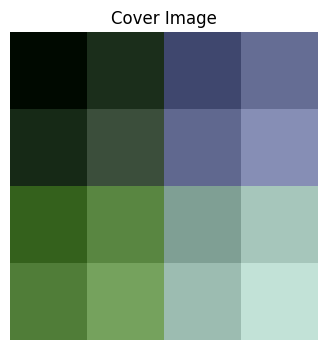

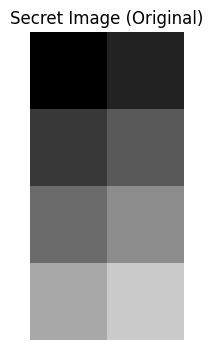

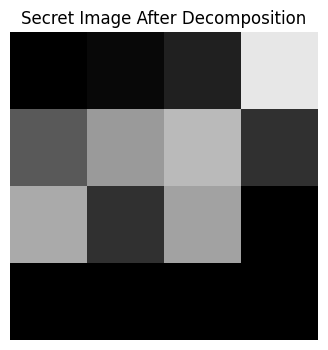

259  1010  011111001001111110010100 101000  101000 100100
275  0110  011000100110100110001100 101110  101110 101011
265  0001  000110000010111000011000 000010  000010 101101
255  0011  011000110000001100010101 111001  111001 110111
254  0101  001110100100111000111000 100110  100110 001101
244  1111  110000001110000011010111 000000  000000 110000
245  1000  001101000110000100011100 101010  101010 000000
297  1001  010110011000011101000011 001100  001100 001010
259  0010  001000000000000000000000 000000  000000 000000
244  1110  100111111011111110110000 000000  000000 110111
234  1101  011101111010000001011111 000000  000000 111000
259  0100  000101100010101000010111 010110  010110 010011
281  1011  101001111100011110111000 000000  000000 001111
260  0111  100001101000111110110100 001100  001100 000011
229  1100  010100000111111100111000 000000  000000 010000
236  0000  000000000000100000000000 000000  000000 000010


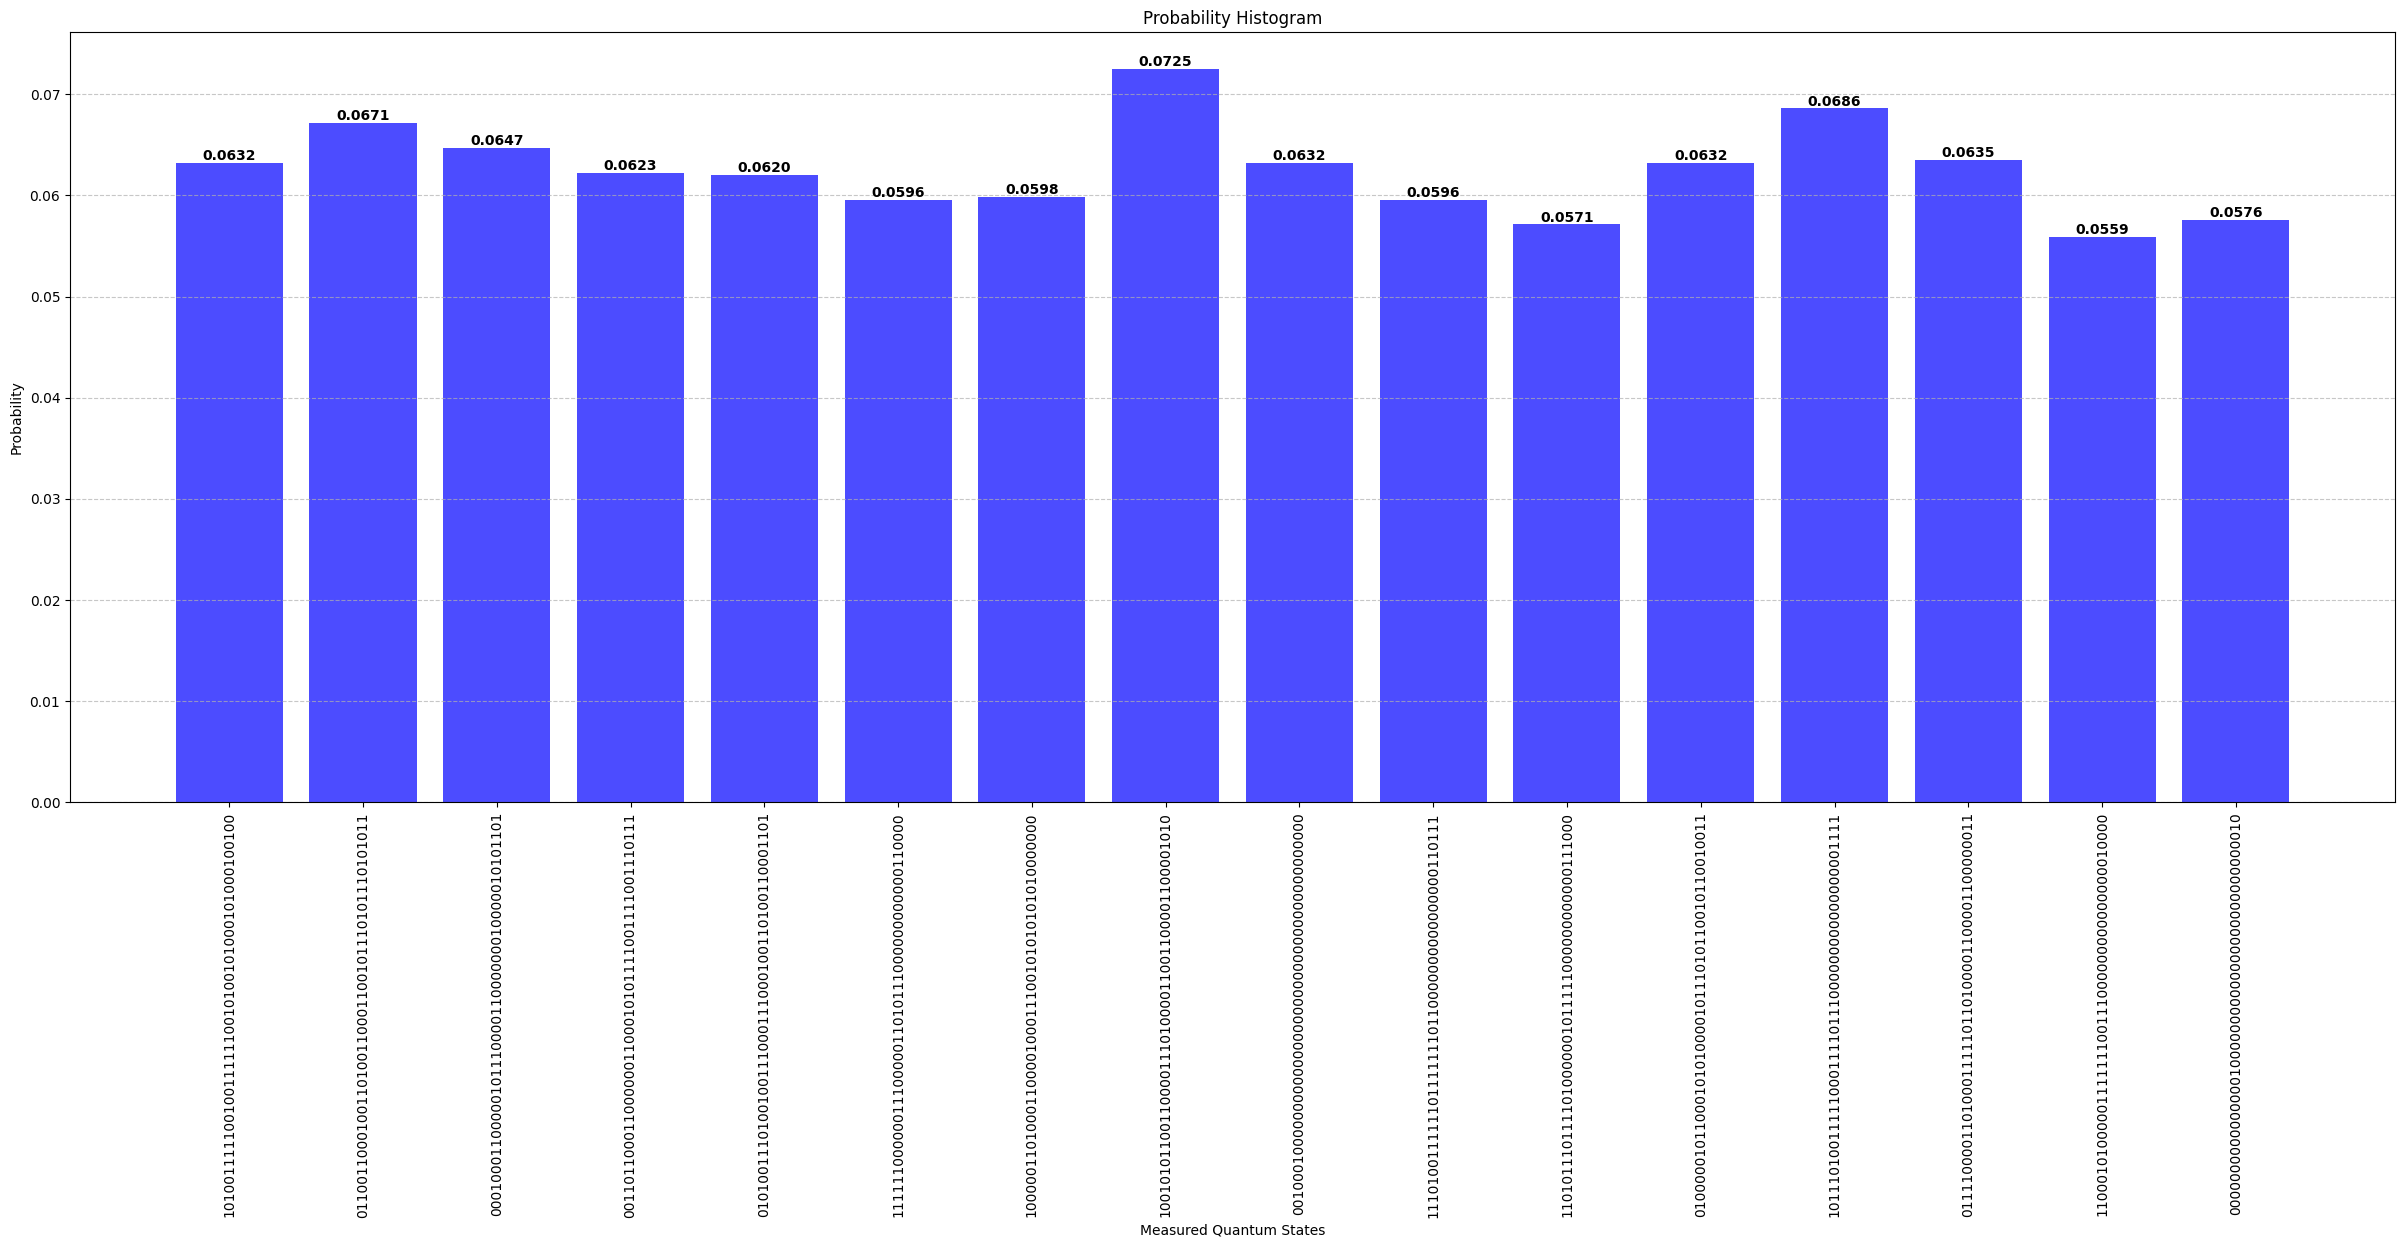

Reconstruction Error Metrics are as follows :
Mean Absolute Error (MAE): 0.2500
Mean Squared Error (MSE): 0.5000
Max Pixel Error : 2
PSNR (dB) : 51.14


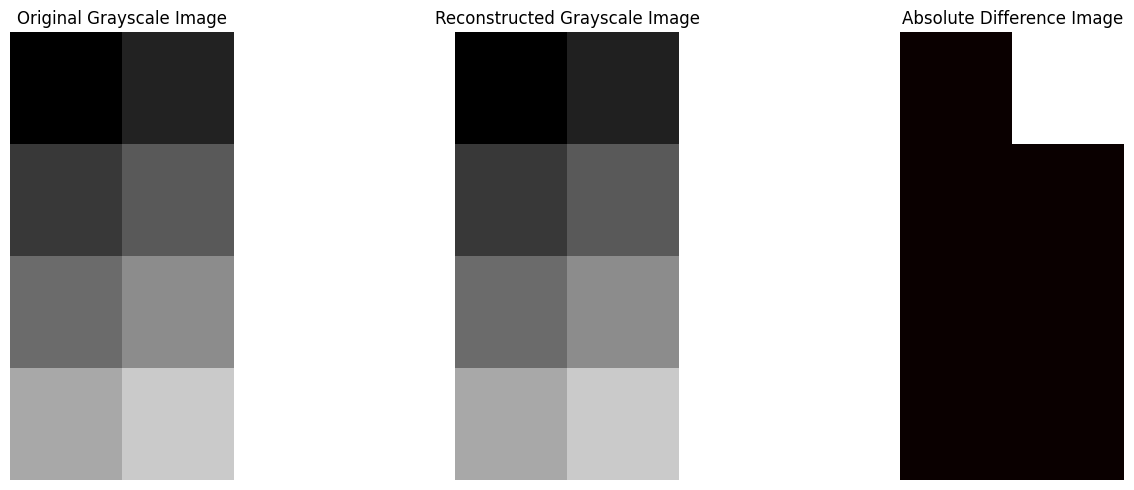

{'MAE': np.float64(0.25), 'MSE': np.float64(0.5), 'MAX_ERROR': np.int64(2), 'PSNR': 51.141103565318915}


In [25]:
master_function('cover_4x4.jpg','secret_4x2.jpg',shots=4096,show_circuit=False)

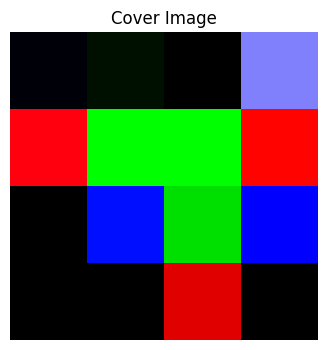

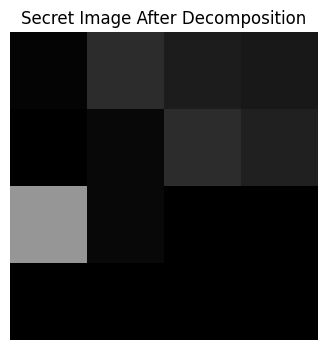

255  1110  111000000000000000000000 000000  000000 000000
253  1111  000000000000000000000000 000000  000000 000000
254  0011  100000011000000111111111 000110  000110 001111
234  0001  000000000001000100000010 001011  001011 001010
249  1001  000000000000111011111111 000010  000010 000000
275  0010  000000010000000100000001 000111  000111 000111
245  0111  111111110000000000000011 001000  001000 011011
257  0100  111000000000000000000000 000000  000000 000000
251  1100  000000000000000000000000 000000  000000 000000
269  1000  000000100000000000000001 100101  100101 100001
246  1101  000000000000000000000000 000000  000000 000000
249  0110  000000001111111000000010 001011  001011 001010
258  1011  000000000000000011111111 000000  000000 000000
252  1010  000000001110000000000000 000000  000000 000000
272  0000  000000000000000000001001 000001  000001 000011
277  0101  000000001111111000000000 000010  000010 000010


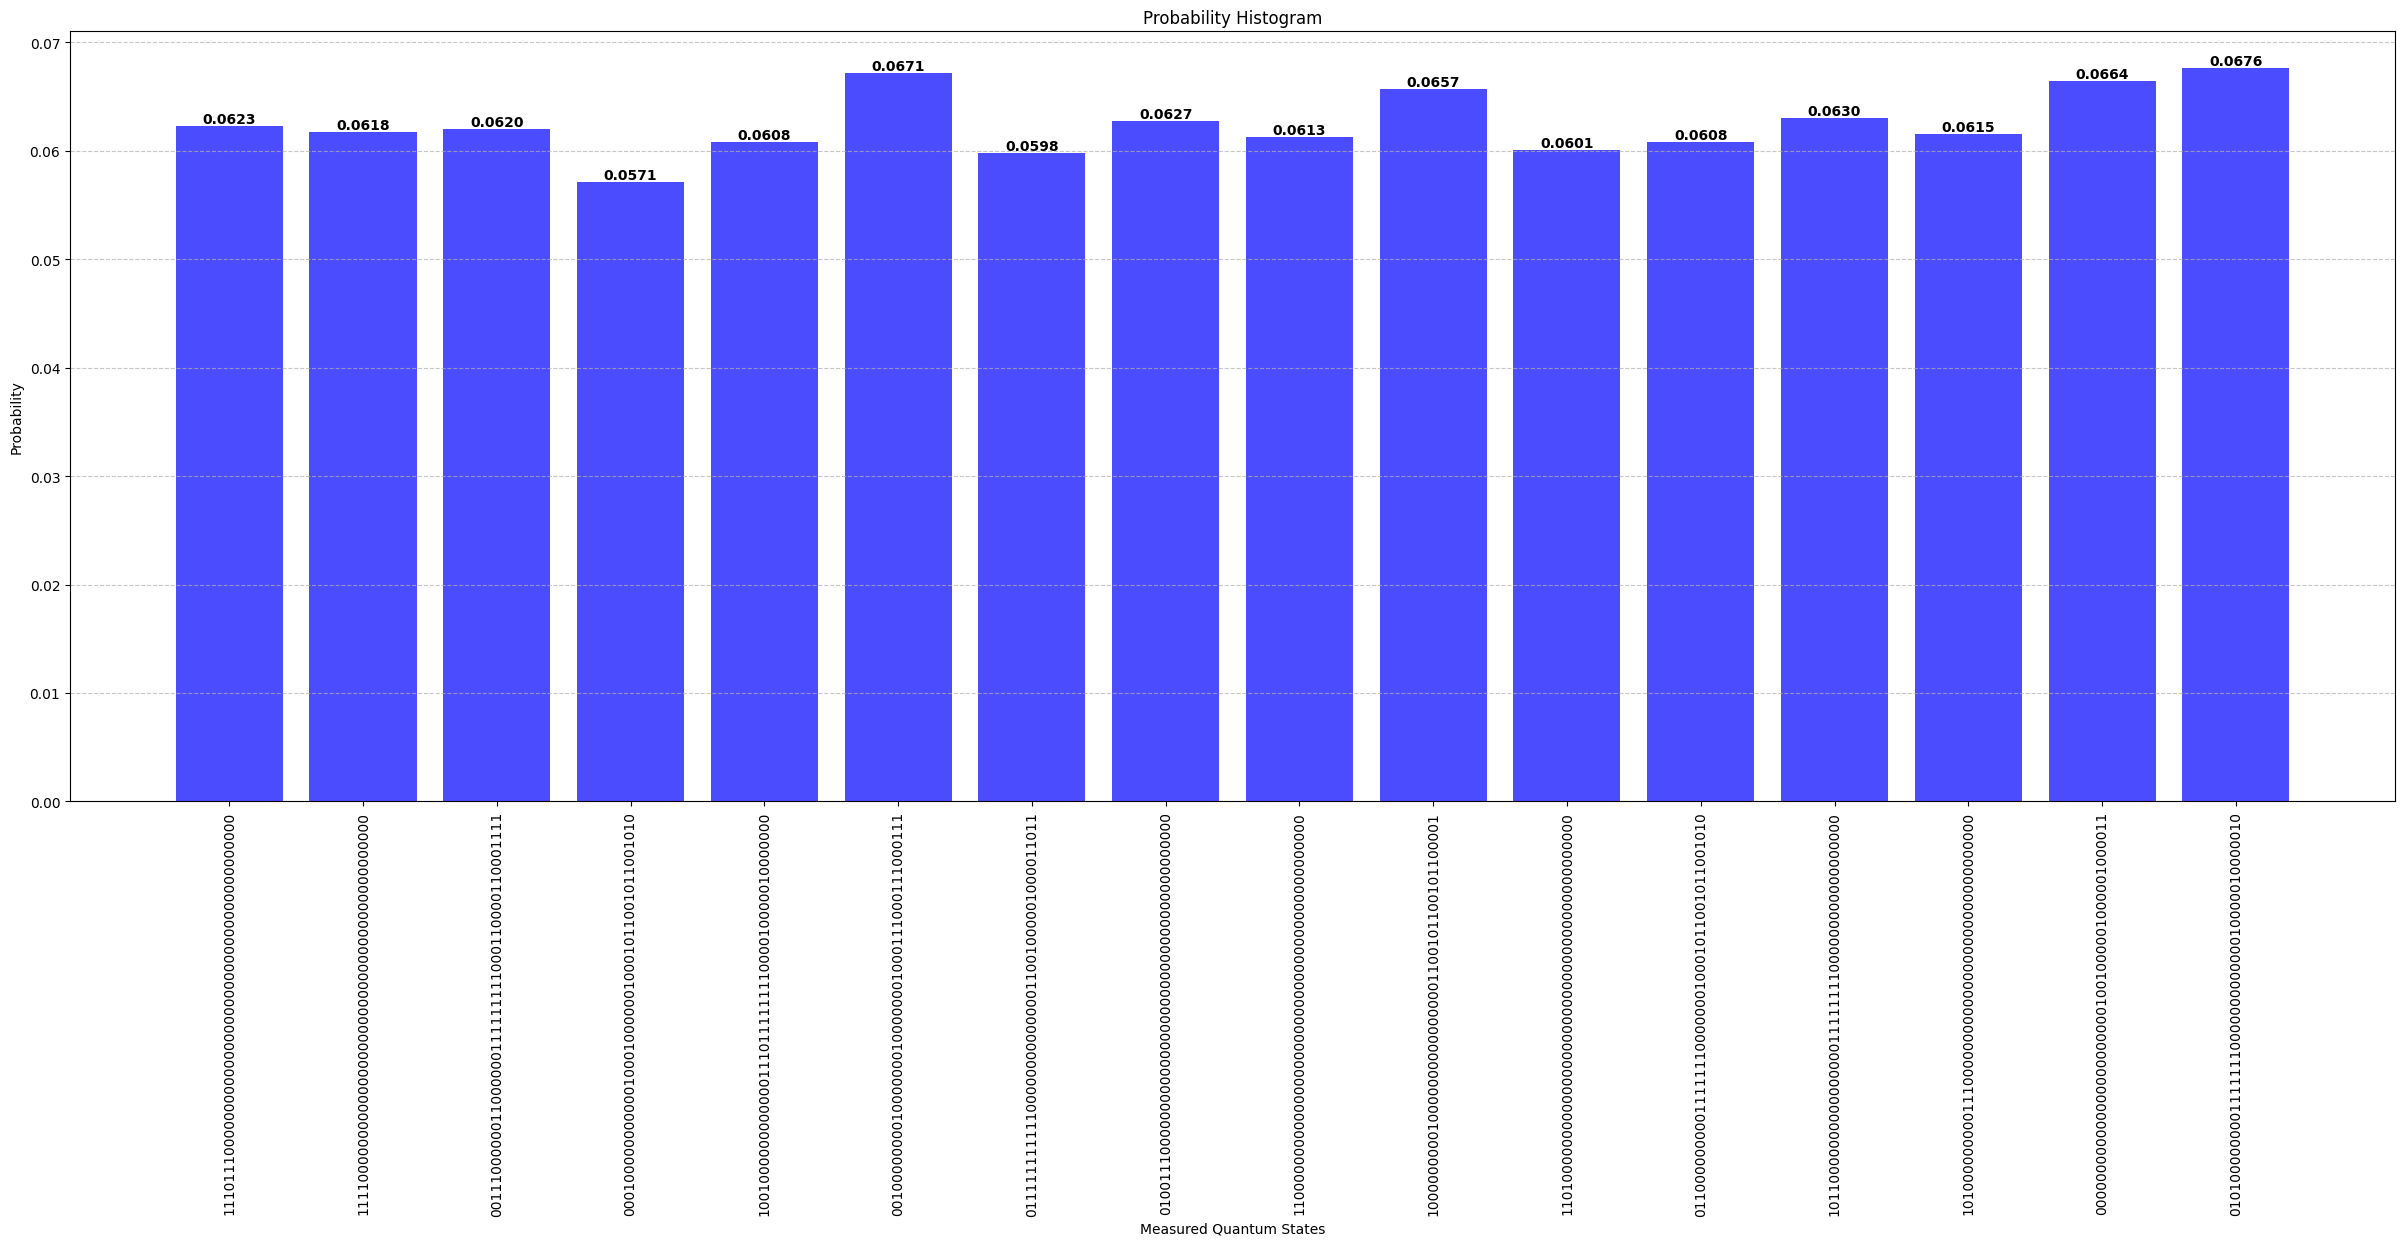

Reconstruction Error Metrics are as follows :
Mean Absolute Error (MAE): 0.0000
Mean Squared Error (MSE): 0.0000
Max Pixel Error : 0
PSNR (dB) : inf


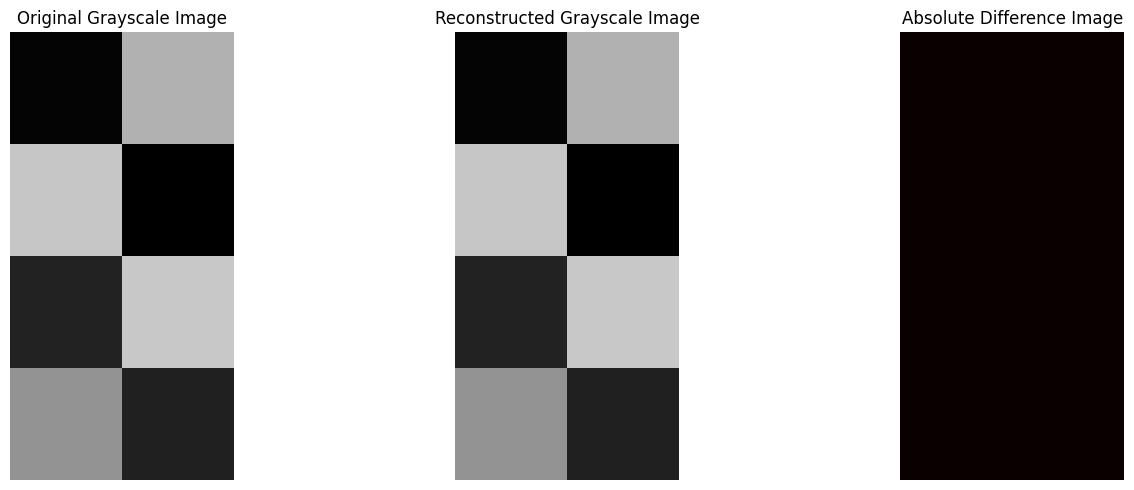

{'MAE': np.float64(0.0), 'MSE': np.float64(0.0), 'MAX_ERROR': np.int64(0), 'PSNR': inf}


In [30]:

img_bin_try = [[['00000000', '00000001', '00001000'],['00000000', '00010000', '00000000'],['00000000', '00000000', '00000000'],['10000000', '10000000', '11111100']],
               [['11111111', '00000000','00001111'],['00000000', '11111111', '00000000'],['00000000', '11111111', '00000000'],['11111111', '00000011', '00000000']],
              [['00000000', '00000000', '00000000'],['00000000', '00001110', '11111111'],['00000000', '11100000', '00000000'],['00000000', '00000000', '11111111']],
              [['00000000', '00000000', '00000000'],['00000000', '00000000', '00000000'],['11100000', '00000000', '00000000'],['00000000', '00000000', '00000000']]]
img_try_6 = [[[0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 1, 1], [0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 0]], 
            [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 1, 1], [0, 0, 1, 0, 0, 0]],
            [[1, 0, 0, 1, 0, 1], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]],
            [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]]
def convert_to_8bit(img_try_6, Hq, Hs, Wq, Ws):
    img_try_len = []
    for h in range(Hq):
        for w in range(Wq):
            for i in range(6):
                img_try_len.append(img_try_6[h][w][i])
    need = 8 * Hs * Ws
    img_try_len = img_try_len[:need]
    img_try = []
    for h in range(Hs):
        row = []
        for w in range(Ws):
            v = 0
            pixel_index = h * Ws + w
            for i in range(8):
                bit = img_try_len[pixel_index * 8 + i]
                v |= bit << (7 - i)
            row.append(v)
        img_try.append(row)

    return img_try              
img_try = convert_to_8bit(img_try_6,4,4,4,2)

display_cover_image_binary(img_bin_try)
# display_secret_before_decomposition(np.array(img_try))
display_secret_after_decomposition(img_try_6)
#Loading the values to QC
qc ,regs = build_qc_full(img_bin_try,img_try_6)
# Displaying
# display_large_circuit(qc, regs,"Circuit")
qc.barrier()

# Measuring the circuit
counts = measure_secret_neqr_after(qc,regs,shots=4096)
for key,value in counts.items():
      print(f"{value}  {str(key)[:4]}  {str(key)[4:28]} {str(key)[28:34]}  {str(key)[34:40]} {str(key)[40:]}")
# Histogram
display_the_hist(counts)
# Reconstruction of secret image
img_rec = reconstruct_secret_grayscale(counts,
                                       ky=len(regs['y']),kx= len(regs['x']),
                                       Hs=4,Ws = 2,
                                       Hq=4,Wq=4 )

# Displaying and comparing the Original and Reconstruction Image
metrics = display_and_compare_grayscale(np.array(img_try),img_rec,show_diff=True) 
print(metrics)

